Using device: cpu


100%|██████████| 170M/170M [00:19<00:00, 8.94MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training MLP model: simple
Epoch [1/15], Simple Model Test Accuracy: 45.73%
Epoch [2/15], Simple Model Test Accuracy: 48.72%
Epoch [3/15], Simple Model Test Accuracy: 50.50%
Epoch [4/15], Simple Model Test Accuracy: 51.50%
Epoch [5/15], Simple Model Test Accuracy: 52.07%
Epoch [6/15], Simple Model Test Accuracy: 52.69%
Epoch [7/15], Simple Model Test Accuracy: 53.61%
Epoch [8/15], Simple Model Test Accuracy: 52.62%
Epoch [9/15], Simple Model Test Accuracy: 53.14%
Epoch [10/15], Simple Model Test Accuracy: 53.66%
Epoch [11/15], Simple Model Test Accuracy: 53.73%
Epoch [12/15], Simple Model Test Accuracy: 54.16%
Epoch [13/15], Simple Model Test Accuracy: 52.98%
Epoch [14/15], Simple Model Test Accuracy: 53.82%
Epoch [15/15], Simple Model Test Accuracy: 53.32%
Training MLP model: batchensemble
Epoch [1/15], Batchensemble Model Test Accuracy: 45.11%
Epoch [2/15], Batchensemble Model Test Accuracy: 48.5

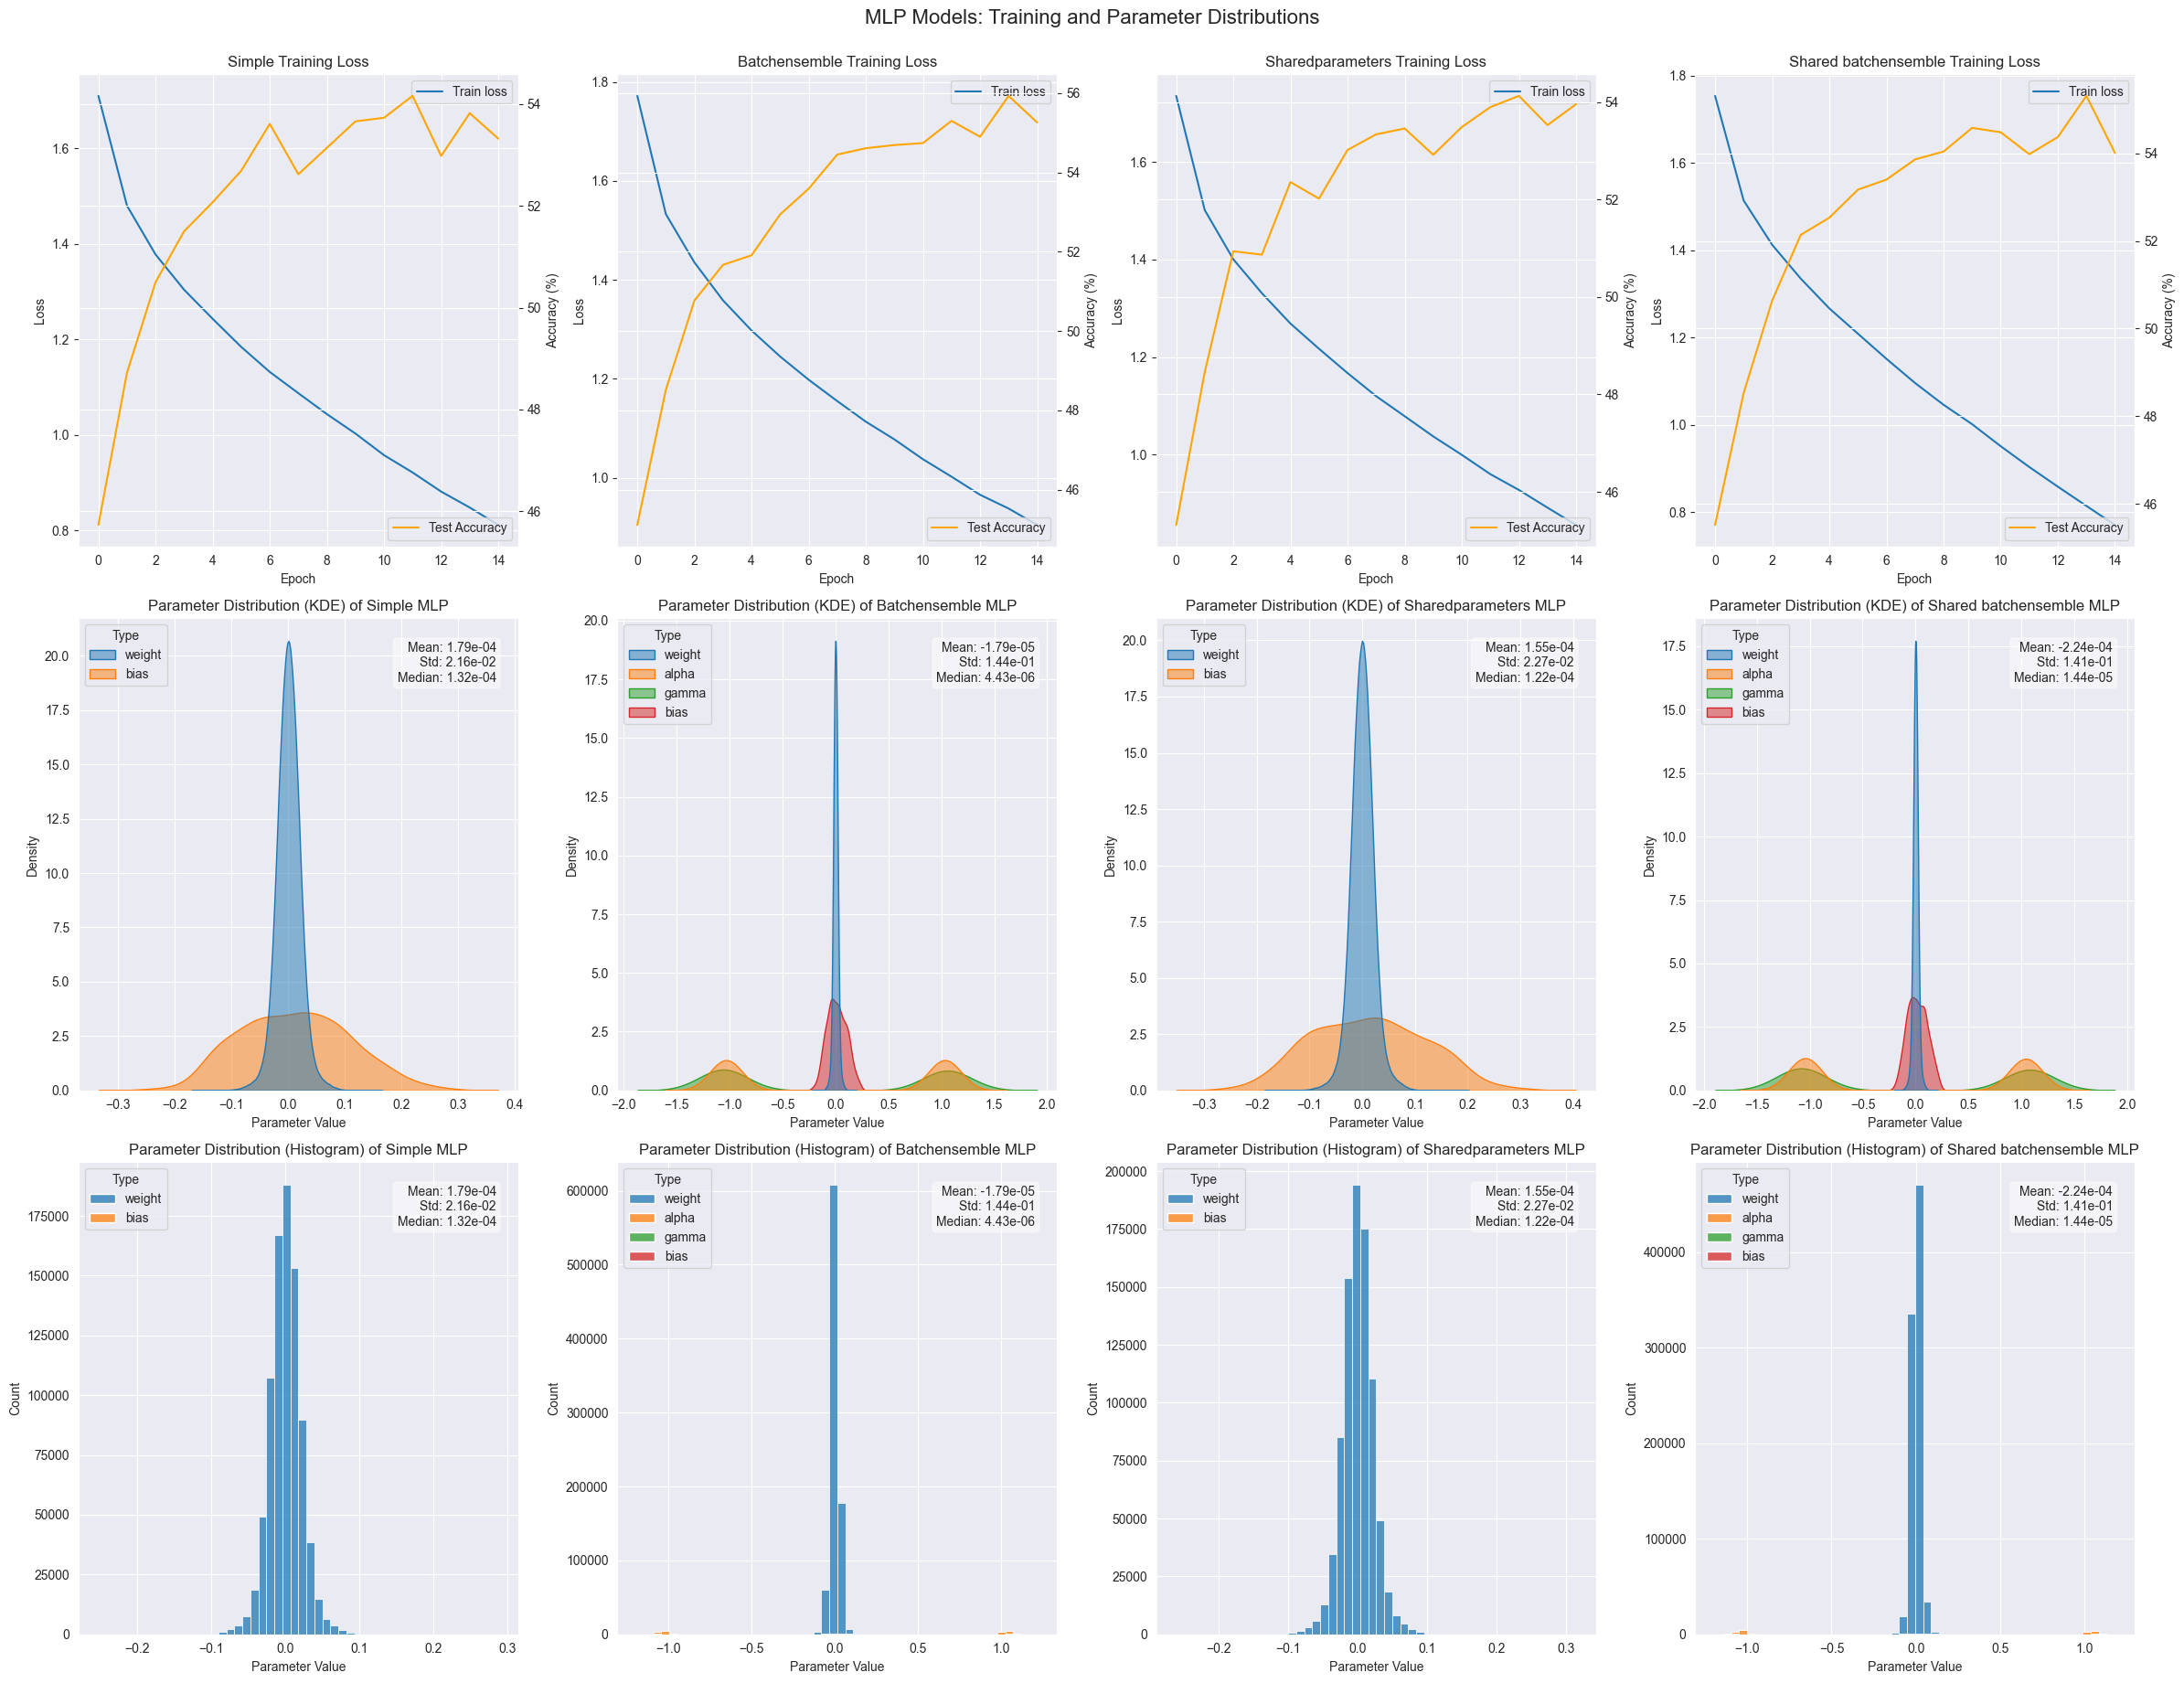

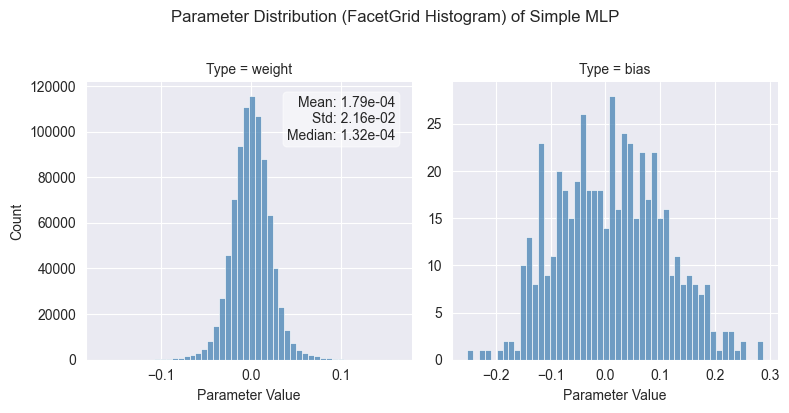

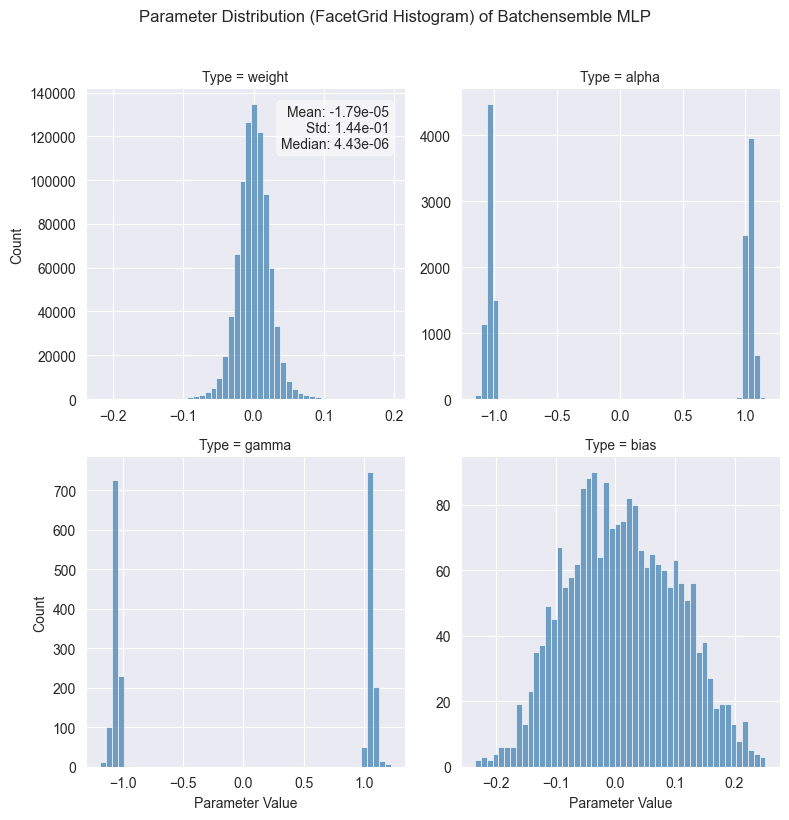

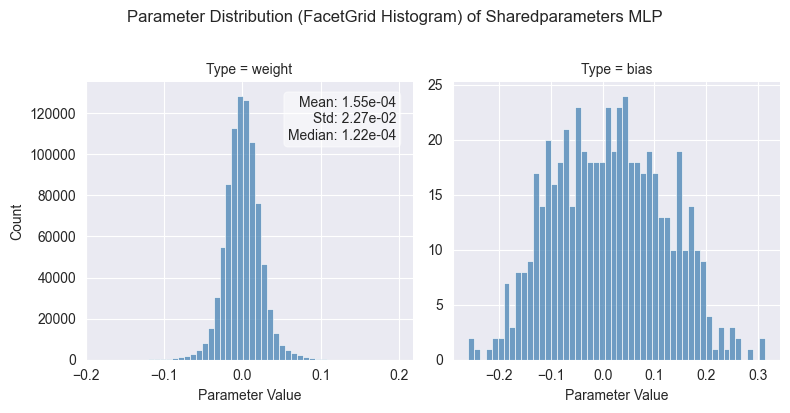

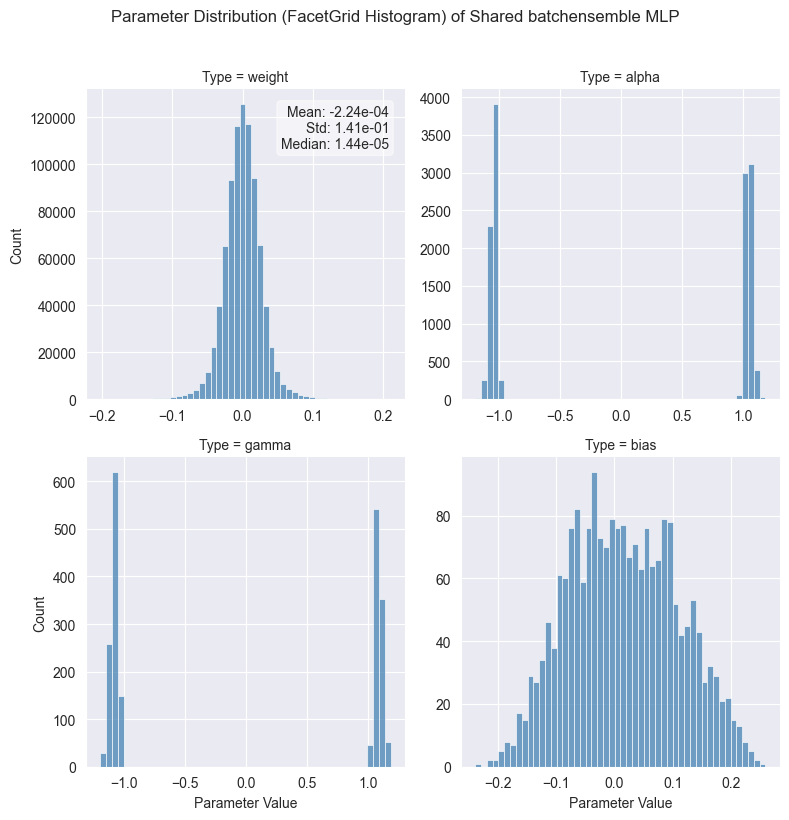

Training CNN model: simple
Epoch [1/15], Simple Model Test Accuracy: 54.86%
Epoch [2/15], Simple Model Test Accuracy: 59.64%
Epoch [3/15], Simple Model Test Accuracy: 63.31%
Epoch [4/15], Simple Model Test Accuracy: 65.97%
Epoch [5/15], Simple Model Test Accuracy: 66.05%
Epoch [6/15], Simple Model Test Accuracy: 67.21%


In [ ]:
import sys
import typer
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import pandas as pd

# BatchEnsemble implementation

def random_sign_(tensor: torch.Tensor, prob: float = 0.5, value: float = 1.0):
    """
    Randomly set elements of the input tensor to either +value or -value.
    """
    sign = torch.where(torch.rand_like(tensor) < prob, 1.0, -1.0)
    with torch.no_grad():
        tensor.copy_(sign * value)

class BatchEnsembleMixin:
    def init_ensemble(
        self,
        in_features: int,
        out_features: int,
        ensemble_size: int,
        alpha_init: float | None = None,
        gamma_init: float | None = None,
        bias: bool = True,
        device=None,
        dtype=None,
    ):
        self.ensemble_size = ensemble_size
        self.alpha_init = alpha_init
        self.gamma_init = gamma_init

        if not isinstance(self, nn.Module):
            raise TypeError("BatchEnsembleMixin must be mixed with nn.Module or one of its subclasses")

        if alpha_init is None:
            self.register_parameter("alpha_param", None)
        else:
            self.alpha_param = self.init_scaling_parameter(alpha_init, in_features, device=device, dtype=dtype)
            self.register_parameter("alpha_param", self.alpha_param)

        if gamma_init is None:
            self.register_parameter("gamma_param", None)
        else:
            self.gamma_param = self.init_scaling_parameter(gamma_init, out_features, device=device, dtype=dtype)
            self.register_parameter("gamma_param", self.gamma_param)

        if bias:
            self.bias_param = nn.Parameter(torch.zeros(ensemble_size, out_features, device=device, dtype=dtype))
            self.register_parameter("bias_param", self.bias_param)
        else:
            self.register_parameter("bias_param", None)

    def init_scaling_parameter(self, init_value: float, num_features: int, device=None, dtype=None):
        param = torch.empty(self.ensemble_size, num_features, device=device, dtype=dtype)
        if init_value < 0:
            param.normal_(mean=1, std=-init_value)
        else:
            random_sign_(param, prob=init_value, value=1.0)
        return nn.Parameter(param)

    def expand_param(self, x: torch.Tensor, param: torch.Tensor):
        num_repeats = x.size(0) // self.ensemble_size
        expanded_param = torch.repeat_interleave(param, num_repeats, dim=0)
        extra_dims = len(x.shape) - len(expanded_param.shape)
        for _ in range(extra_dims):
            expanded_param = expanded_param.unsqueeze(-1)
        return expanded_param

class BELinear(nn.Linear, BatchEnsembleMixin):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        ensemble_size: int = 1,
        alpha_init: float | None = None,
        gamma_init: float | None = None,
        device=None,
        dtype=None,
    ):
        super().__init__(in_features, out_features, bias=False, device=device, dtype=dtype)
        self.init_ensemble(in_features, out_features, ensemble_size, alpha_init, gamma_init, bias)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        if self.alpha_init is not None:
            input = input * self.expand_param(input, self.alpha_param)
        x = F.linear(input, self.weight)
        if self.gamma_init is not None:
            x = x * self.expand_param(x, self.gamma_param)
        if self.bias_param is not None:
            x = x + self.expand_param(x, self.bias_param)
        return x

class Conv2d(nn.Conv2d, BatchEnsembleMixin):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias: bool = True,
        padding_mode='zeros',
        ensemble_size: int = 1,
        alpha_init: float | None = None,
        gamma_init: float | None = None,
        device=None,
        dtype=None,
    ):
        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False,  # Bias is managed separately
            padding_mode=padding_mode,
            device=device,
            dtype=dtype
        )
        self.init_ensemble(
            in_features=in_channels,
            out_features=out_channels,
            ensemble_size=ensemble_size,
            alpha_init=alpha_init,  # Corrected from alpha_gamma_init
            gamma_init=gamma_init,  # Corrected from alpha_gamma_init
            bias=bias,
            device=device,
            dtype=dtype
        )
        
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        if self.alpha_init is not None:
            input = input * self.expand_param(input, self.alpha_param)
        x = self._conv_forward(input, self.weight, None)
        if self.gamma_init is not None:
            x = x * self.expand_param(x, self.gamma_param)
        if self.bias_param is not None:
            x = x + self.expand_param(x, self.bias_param)
        return x

class BatchNorm2d(nn.BatchNorm2d):
    def __init__(
        self,
        num_features: int,
        eps=1e-5,
        momentum=0.1,
        affine=False,  # We will manage affine parameters ourselves
        track_running_stats=True,
        device=None,
        dtype=None,
        ensemble_size: int = 1,
    ):
        super().__init__(
            num_features,
            eps=eps,
            momentum=momentum,
            affine=affine,
            track_running_stats=track_running_stats,
            device=device,
            dtype=dtype
        )
        self.ensemble_size = ensemble_size
        # Correct tensor initialization
        self.weight_be = nn.Parameter(torch.empty(self.ensemble_size, num_features, device=device, dtype=dtype))
        self.bias_be = nn.Parameter(torch.empty(self.ensemble_size, num_features, device=device, dtype=dtype))
        self.reset_be_parameters()

    def reset_be_parameters(self):
        nn.init.ones_(self.weight_be)
        nn.init.zeros_(self.bias_be)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # Use the base class's forward method
        x = super().forward(input)
        num_repeats = x.size(0) // self.ensemble_size
        weight = torch.repeat_interleave(self.weight_be, num_repeats, dim=0).unsqueeze(2).unsqueeze(3)
        bias = torch.repeat_interleave(self.bias_be, num_repeats, dim=0).unsqueeze(2).unsqueeze(3)
        x = x * weight + bias
        return x

# StandardScaler
class StandardScaler:
    """
    Based on https://gist.github.com/farahmand-m/8a416f33a27d73a149f92ce4708beb40
    Extended with inverse_transform
    """

    def __init__(
        self,
        mean: torch.Tensor | None = None,
        std: torch.Tensor | None = None,
        epsilon: float = 1e-8,
    ):
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, data: torch.Tensor):
        reduction_axes = list(range(data.dim() - 1))
        self.mean = torch.mean(data, dim=reduction_axes)
        self.std = torch.std(data, dim=reduction_axes)
        return self

    def transform(self, data: torch.Tensor) -> torch.Tensor:
        if self.mean is None or self.std is None:
            raise RuntimeError("Call fit before calling transform.")
        scaled_mean = (data - self.mean) / (self.std + self.epsilon)
        return scaled_mean

    def inverse_transform(self, scaled_data: torch.Tensor) -> torch.Tensor:
        if self.mean is None or self.std is None:
            raise RuntimeError("Call fit before calling inverse_transform.")
        unscaled_mean = scaled_data * (self.std + self.epsilon) + self.mean
        return unscaled_mean

    def fit_transform(self, data: torch.Tensor) -> torch.Tensor:
        self.fit(data)
        return self.transform(data)

    def to(self, target_device: torch.device):
        if self.mean is not None and self.std is not None:
            self.mean = self.mean.to(target_device)
            self.std = self.std.to(target_device)
        return self

# MLP Models for MNIST

class MLP(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=256, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

class SharedParametersMLP(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=256, num_classes=10, num_heads=4):
        super(SharedParametersMLP, self).__init__()
        self.num_heads = num_heads
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        # Multiple heads for classification
        self.heads = nn.ModuleList([nn.Linear(hidden_size, num_classes) for _ in range(num_heads)])

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.relu2(self.fc2(x))
        # Collect outputs from all heads
        outputs = [head(x) for head in self.heads]
        outputs = torch.stack(outputs)  # Shape: [num_heads, batch_size, num_classes]
        # Average the outputs over heads
        x = outputs.mean(dim=0)  # Shape: [batch_size, num_classes]
        return x

class BatchEnsembleMLP(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=256, num_classes=10, ensemble_size=4, alpha=0.5, gamma=0.5):
        super(BatchEnsembleMLP, self).__init__()
        self.num_classes = num_classes
        self.ensemble_size = ensemble_size
        self.fc1 = BELinear(
            input_size,
            hidden_size,
            ensemble_size=ensemble_size,
            alpha_init=alpha,
            gamma_init=gamma,
        )
        self.relu = nn.ReLU()
        self.fc2 = BELinear(
            hidden_size,
            hidden_size,
            ensemble_size=ensemble_size,
            alpha_init=alpha,
            gamma_init=gamma,
        )
        self.relu2 = nn.ReLU()
        self.fc3 = BELinear(
            hidden_size,
            num_classes,
            ensemble_size=ensemble_size,
            alpha_init=alpha,
            gamma_init=gamma,
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

class SharedParametersBatchEnsembleMLP(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=256, num_classes=10, ensemble_size=4, alpha=0.5, gamma=0.5):
        super(SharedParametersBatchEnsembleMLP, self).__init__()
        self.num_classes = num_classes
        self.ensemble_size = ensemble_size
        self.relu = nn.ReLU()
        self.relu2 = nn.ReLU()

        # Shared BatchEnsemble layers
        self.fc1 = BELinear(
            input_size,
            hidden_size,
            ensemble_size=ensemble_size,
            alpha_init=alpha,
            gamma_init=gamma,
        )
        self.fc2 = BELinear(
            hidden_size,
            hidden_size,
            ensemble_size=ensemble_size,
            alpha_init=alpha,
            gamma_init=gamma,
        )

        # Multiple heads for classification
        self.heads = nn.ModuleList([
            nn.Linear(hidden_size, num_classes) for _ in range(ensemble_size)
        ])

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten

        # Pass through shared BatchEnsemble layers
        x = self.relu(self.fc1(x))
        x = self.relu2(self.fc2(x))

        # Reshape x to [ensemble_size, batch_size, hidden_size]
        batch_size = x.size(0) // self.ensemble_size
        x = x.view(self.ensemble_size, batch_size, -1)

        # Apply each head and collect outputs
        outputs = []
        for i, head in enumerate(self.heads):
            out = head(x[i])  # x[i] is [batch_size, hidden_size]
            outputs.append(out)

        # Stack outputs: Shape [ensemble_size, batch_size, num_classes]
        outputs = torch.stack(outputs)  # Shape: [ensemble_size, batch_size, num_classes]

        # Average over ensemble members
        outputs = outputs.mean(dim=0)  # Shape: [batch_size, num_classes]

        return outputs
        
# CNN Models

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.num_classes = 10
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Changed input channels to 3
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64 * 8 * 8, 10)  # Adjusted input size

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # [batch_size, 32, 32, 32]
        x = self.pool(x)                        # [batch_size, 32, 16, 16]
        x = self.relu(self.bn2(self.conv2(x)))  # [batch_size, 64, 16, 16]
        x = self.pool(x)                        # [batch_size, 64, 8, 8]
        x = x.view(x.size(0), -1)               # [batch_size, 64*8*8]
        x = self.fc(x)                          # [batch_size, 10]
        return x

class SharedParametersCNN(nn.Module):
    def __init__(self, num_heads=4):
        super(SharedParametersCNN, self).__init__()
        self.num_heads = num_heads
        self.num_classes = 10
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Changed input channels to 3
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.shared_fc = nn.Linear(64 * 8 * 8, 128)  # Adjusted input size
        # Multiple heads for classification
        self.heads = nn.ModuleList([nn.Linear(128, 10) for _ in range(num_heads)])

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # [batch_size, 32, 32, 32]
        x = self.pool(x)                        # [batch_size, 32, 16, 16]
        x = self.relu(self.bn2(self.conv2(x)))  # [batch_size, 64, 16, 16]
        x = self.pool(x)                        # [batch_size, 64, 8, 8]
        x = x.view(x.size(0), -1)               # [batch_size, 64*8*8]
        x = self.shared_fc(x)                   # [batch_size, 128]
        # Collect outputs from all heads
        outputs = [head(x) for head in self.heads]
        outputs = torch.stack(outputs)           # Shape: [num_heads, batch_size, num_classes]
        # Average the outputs over heads
        x = outputs.mean(dim=0)                  # Shape: [batch_size, num_classes]
        return x

class BatchEnsembleCNN(nn.Module):
    def __init__(self, ensemble_size=4, alpha=0.5, gamma=0.5):
        super(BatchEnsembleCNN, self).__init__()
        self.num_classes = 10
        self.ensemble_size = ensemble_size
        self.conv1 = Conv2d(3, 32, kernel_size=3, padding=1,  # Changed input channels to 3
                            ensemble_size=ensemble_size,
                            alpha_init=alpha,
                            gamma_init=gamma)
        self.bn1 = BatchNorm2d(32, ensemble_size=ensemble_size)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = Conv2d(32, 64, kernel_size=3, padding=1,
                            ensemble_size=ensemble_size,
                            alpha_init=alpha,
                            gamma_init=gamma)
        self.bn2 = BatchNorm2d(64, ensemble_size=ensemble_size)
        self.fc = BELinear(64 * 8 * 8, 10,  # Adjusted input size
                           ensemble_size=ensemble_size,
                           alpha_init=alpha,
                           gamma_init=gamma)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))   # [batch_size * ensemble_size, 32, 32, 32]
        x = self.pool(x)                         # [batch_size * ensemble_size, 32, 16, 16]
        x = self.relu(self.bn2(self.conv2(x)))   # [batch_size * ensemble_size, 64, 16, 16]
        x = self.pool(x)                         # [batch_size * ensemble_size, 64, 8, 8]
        x = x.view(x.size(0), -1)                # [batch_size * ensemble_size, 64*8*8]
        x = self.fc(x)                           # [batch_size * ensemble_size, 10]
        return x

class SharedParametersBatchEnsembleCNN(nn.Module):
    def __init__(self, ensemble_size=4, alpha=0.5, gamma=0.5):
        super(SharedParametersBatchEnsembleCNN, self).__init__()
        self.ensemble_size = ensemble_size
        self.num_classes = 10
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        
        # Shared BatchEnsemble convolutional layers
        self.conv1 = Conv2d(
            3, 32, kernel_size=3, padding=1,  # Changed input channels to 3
            ensemble_size=ensemble_size,
            alpha_init=alpha,
            gamma_init=gamma
        )
        self.bn1 = BatchNorm2d(32, ensemble_size=ensemble_size)
        self.conv2 = Conv2d(
            32, 64, kernel_size=3, padding=1,
            ensemble_size=ensemble_size,
            alpha_init=alpha,
            gamma_init=gamma
        )
        self.bn2 = BatchNorm2d(64, ensemble_size=ensemble_size)
        
        # Shared fully connected layer
        self.shared_fc = BELinear(
            64 * 8 * 8, 128,  # Adjusted input size
            ensemble_size=ensemble_size,
            alpha_init=alpha,
            gamma_init=gamma
        )
        
        # Multiple heads for classification
        self.heads = nn.ModuleList([
            nn.Linear(128, self.num_classes) for _ in range(ensemble_size)
        ])
    
    def forward(self, x):
        # Shared convolutional layers
        x = self.relu(self.bn1(self.conv1(x)))  # Shape: [batch_size * ensemble_size, 32, 32, 32]
        x = self.pool(x)                        # Shape: [batch_size * ensemble_size, 32, 16, 16]
        x = self.relu(self.bn2(self.conv2(x)))  # Shape: [batch_size * ensemble_size, 64, 16, 16]
        x = self.pool(x)                        # Shape: [batch_size * ensemble_size, 64, 8, 8]
        x = x.view(x.size(0), -1)               # Shape: [batch_size * ensemble_size, 64*8*8]

        # Shared fully connected layer
        x = self.shared_fc(x)                   # Shape: [batch_size * ensemble_size, 128]

        # Reshape x to [ensemble_size, batch_size, 128]
        batch_size = x.size(0) // self.ensemble_size
        x = x.view(self.ensemble_size, batch_size, -1)

        # Apply each head and collect outputs
        outputs = []
        for i, head in enumerate(self.heads):
            out = head(x[i])  # x[i] is [batch_size, 128]
            outputs.append(out)

        # Stack outputs: Shape [ensemble_size, batch_size, num_classes]
        outputs = torch.stack(outputs)  # Shape: [ensemble_size, batch_size, num_classes]

        # Average over ensemble members
        outputs = outputs.mean(dim=0)  # Shape: [batch_size, num_classes]

        return outputs

# Training and visualization functions

def train_mnist_model(
    model,
    train_loader,
    test_loader,
    model_type="simple",
    ensemble_size=4,
    num_epochs=15,
    lr=0.0002,
    device=torch.device("cpu"),
):
    model.to(device)  # Move the model to the GPU if available
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            if model_type == "batchensemble":
                # Repeat images and labels for BatchEnsemble
                images = images.repeat(ensemble_size, 1, 1, 1)
                labels = labels.repeat(ensemble_size)
            elif model_type == "shared_batchensemble":
                # Repeat images only
                images = images.repeat(ensemble_size, 1, 1, 1)
                # Do not repeat labels
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        # Evaluate model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                if model_type == "batchensemble":
                    images = images.repeat(ensemble_size, 1, 1, 1)
                    outputs = model(images)
                    # Reshape and average over ensemble instances
                    outputs = outputs.view(ensemble_size, -1, model.num_classes)
                    outputs = outputs.mean(dim=0)
                elif model_type == "shared_batchensemble":
                    images = images.repeat(ensemble_size, 1, 1, 1)
                    outputs = model(images)
                else:
                    outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], {model_type.replace("_", " ").capitalize()} Model Test Accuracy: {test_accuracy:.2f}%')

    return train_losses, test_accuracies
    
def plot_training_results(train_losses, test_accuracies, ax, model_type="simple"):
    ax.plot(train_losses, label="Train loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(f"{model_type.replace('_', ' ').capitalize()} Training Loss")
    ax.legend()

    ax2 = ax.twinx()
    ax2.plot(test_accuracies, label="Test Accuracy", color="orange")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend(loc='lower right')
    
@torch.no_grad()
def plot_parameters(model, model_name="Model", plot_type="kde", ax=None):
    """
    Plots the distribution of model parameters using different plot types.

    Parameters:
    - model (nn.Module): The PyTorch model whose parameters are to be plotted.
    - model_name (str): A name for the model to be displayed in the plot titles.
    - plot_type (str): The type of plot to generate. Options are:
        - 'kde': Kernel Density Estimate plot.
        - 'histogram': Combined histogram for all parameter types.
        - 'facet_hist': FacetGrid of histograms separated by parameter type.
    - ax (matplotlib.axes.Axes, optional): The axes on which to plot. Required for 'kde' and 'histogram' types.
                                           Not used for 'facet_hist' as it creates its own figure.
    """
    # Collect all parameters and categorize them by type
    params = []
    tags = []
    for name, param in model.named_parameters():
        if "bias" in name:
            tag = "bias"
        elif "alpha" in name:
            tag = "alpha"
        elif "gamma" in name:
            tag = "gamma"
        elif "weight" in name:
            tag = "weight"
        else:
            tag = "other"
        params.append(param.detach().cpu().flatten())
        tags += [tag] * param.numel()
    
    # Concatenate all parameters into a single array
    params = torch.cat(params).numpy()
    tags = np.array(tags)
    
    # Create a DataFrame for seaborn
    df = pd.DataFrame({
        'Parameter Value': params,
        'Type': tags
    })
    
    # Compute statistics
    mean = np.mean(params)
    std = np.std(params)
    median = np.median(params)
    
    # Plot based on the specified plot type
    if plot_type == "kde":
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
        sns.kdeplot(
            data=df,
            x='Parameter Value',
            hue='Type',
            ax=ax,
            fill=True,
            common_norm=False,  # Normalize each KDE separately
            alpha=0.5
        )
        ax.set_xlabel("Parameter Value")
        ax.set_ylabel("Density")
        ax.set_title(f"Parameter Distribution (KDE) of {model_name}")
        # Display statistics
        ax.text(0.95, 0.95, f"Mean: {mean:.2e}\nStd: {std:.2e}\nMedian: {median:.2e}",
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    elif plot_type == "histogram":
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
        sns.histplot(
            data=df,
            x='Parameter Value',
            hue='Type',
            multiple='stack',
            bins=50,
            kde=False,
            ax=ax
        )
        ax.set_xlabel("Parameter Value")
        ax.set_ylabel("Count")
        ax.set_title(f"Parameter Distribution (Histogram) of {model_name}")
        # Display statistics
        ax.text(0.95, 0.95, f"Mean: {mean:.2e}\nStd: {std:.2e}\nMedian: {median:.2e}",
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    elif plot_type == "facet_hist":
        # Create a FacetGrid of histograms separated by parameter type
        g = sns.FacetGrid(df, col="Type", col_wrap=2, sharex=False, sharey=False, height=4)
        g.map_dataframe(sns.histplot, x="Parameter Value", bins=50, kde=False, color="steelblue")
        g.set_axis_labels("Parameter Value", "Count")
        g.fig.suptitle(f"Parameter Distribution (FacetGrid Histogram) of {model_name}", y=1.02)
        # Adjust layout
        plt.tight_layout()
        # Display statistics on the first subplot
        if len(g.axes.flat) > 0:
            ax0 = g.axes.flat[0]
            ax0.text(0.95, 0.95, f"Mean: {mean:.2e}\nStd: {std:.2e}\nMedian: {median:.2e}",
                     transform=ax0.transAxes, fontsize=10,
                     verticalalignment='top', horizontalalignment='right',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    else:
        raise ValueError("Invalid plot_type. Choose from 'kde', 'histogram', or 'facet_hist'.")

app = typer.Typer()

def train_with_params(
    seed: int = typer.Option(42, help="Size of the seed"),   
    ensemble_size: int = typer.Option(4, help="Size of the ensemble"),
    alpha_init: float = typer.Option(0.5, help="Initial value for Alpha in BatchEnsemble"),
    gamma_init: float = typer.Option(0.5, help="Initial value for Gamma in BatchEnsemble"),
    num_epochs: int = typer.Option(15, help="Number of training epochs"),
    batch_size: int = typer.Option(256, help="Batch size for training"),
    lr: float = typer.Option(0.0002, help="Learning rate for the optimizer"),
    device: str = typer.Option("cpu", help="Device to use, 'cuda' for GPU or 'cpu' for CPU")
):
    
    torch.manual_seed(seed)
    num_heads = ensemble_size  # For consistency
    
    
    # Ensure that batch_size is divisible by ensemble_size
    if batch_size % ensemble_size != 0:
        raise ValueError("Batch size must be divisible by ensemble size.")

    # Define transformations for CIFAR-10
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10 mean
            std=[0.2023, 0.1994, 0.2010]    # CIFAR-10 std
        ),
    ])

    # Load CIFAR-10 dataset
    train_dataset = datasets.CIFAR10(root='./data', train=True,
                                     download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False,
                                    download=True, transform=transform)

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    # Define model types
    model_types = ["simple", "batchensemble", "sharedparameters", "shared_batchensemble"]

    # Initialize dictionaries to store models and their metrics
    mlp_models = {}
    mlp_train_losses = {}
    mlp_test_accuracies = {}

    # Train and evaluate MLP models
    for model_type in model_types:
        if model_type == "simple":
            model = MLP().to(device)
            ensemble_size_mlp = 1
        elif model_type == "batchensemble":
            model = BatchEnsembleMLP(
                ensemble_size=ensemble_size,
                alpha=alpha_init,
                gamma=gamma_init
            ).to(device)
            ensemble_size_mlp = ensemble_size
        elif model_type == "sharedparameters":
            model = SharedParametersMLP(
                num_heads=num_heads
            ).to(device)
            ensemble_size_mlp = 1  # Shared parameters handle multiple heads internally
        elif model_type == "shared_batchensemble":
            model = SharedParametersBatchEnsembleMLP(
                ensemble_size=ensemble_size,
                alpha=alpha_init,
                gamma=gamma_init
            ).to(device)
            ensemble_size_mlp = ensemble_size
        else:
            raise ValueError("Invalid model_type.")
        mlp_models[model_type] = model
        print(f"Training MLP model: {model_type}")
        tr_losses, te_accuracies = train_mnist_model(
            model,
            train_loader,
            test_loader,
            model_type=model_type,
            ensemble_size=ensemble_size_mlp,
            num_epochs=num_epochs,
            lr=lr,
            device=device,  # Ensure device is passed
        )
        mlp_train_losses[model_type] = tr_losses
        mlp_test_accuracies[model_type] = te_accuracies

    # Plot MLP training results and parameter distributions
    # Define plot types
    plot_types = ["kde", "histogram"]  # Add "facet_hist" if desired

    # Create a figure with subplots for training results and parameter plots
    num_models = len(model_types)
    num_plot_types = len(plot_types)
    fig, axs = plt.subplots(num_plot_types + 1, num_models, figsize=(24, 18))  # +1 for training plots

    for i, model_type in enumerate(model_types):
        # Plot training loss and test accuracy on the first row
        plot_training_results(
            mlp_train_losses[model_type],
            mlp_test_accuracies[model_type],
            axs[0, i],
            model_type=model_type
        )
        # Plot parameter distributions for each plot type
        for j, plot_type in enumerate(plot_types):
            plot_parameters(
                mlp_models[model_type],
                model_name=f"{model_type.replace('_', ' ').capitalize()} MLP",
                plot_type=plot_type,
                ax=axs[j + 1, i]
            )
            # Optional: Remove any additional plot types by commenting them out

    # Adjust layout and add a main title
    plt.tight_layout()
    fig.suptitle("MLP Models: Training and Parameter Distributions", fontsize=16, y=1.02)
    plt.show()

    # Optional: Create separate FacetGrid histograms for each MLP model
    for model_type in model_types:
        plot_parameters(
            mlp_models[model_type],
            model_name=f"{model_type.replace('_', ' ').capitalize()} MLP",
            plot_type="facet_hist"
        )
        plt.show()
        # Optional: Comment out the plt.show() if you do not want to display each plot immediately

    # Initialize dictionaries to store CNN models and their metrics
    cnn_models = {}
    cnn_train_losses = {}
    cnn_test_accuracies = {}

# Train and evaluate CNN models
    for model_type in model_types:
        if model_type == "simple":
            model = SimpleCNN().to(device)
            ensemble_size_cnn = 1
        elif model_type == "batchensemble":
            model = BatchEnsembleCNN(
                ensemble_size=ensemble_size,
                alpha=alpha_init,
                gamma=gamma_init
            ).to(device)
            ensemble_size_cnn = ensemble_size
        elif model_type == "sharedparameters":
            model = SharedParametersCNN(
                num_heads=num_heads
            ).to(device)
            ensemble_size_cnn = 1  # Shared parameters handle multiple heads internally
        elif model_type == "shared_batchensemble":
            model = SharedParametersBatchEnsembleCNN(
                ensemble_size=ensemble_size,
                alpha=alpha_init,
                gamma=gamma_init
            ).to(device)
            ensemble_size_cnn = ensemble_size
        else:
            raise ValueError("Invalid model_type.")
        cnn_models[model_type] = model
        print(f"Training CNN model: {model_type}")
        tr_losses, te_accuracies = train_mnist_model(
            model,
            train_loader,
            test_loader,
            model_type=model_type,
            ensemble_size=ensemble_size_cnn,
            num_epochs=num_epochs,
            lr=lr,
            device=device,  # Ensure device is passed
        )
        cnn_train_losses[model_type] = tr_losses
        cnn_test_accuracies[model_type] = te_accuracies

    # Plot CNN training results and parameter distributions
    # Define plot types
    plot_types = ["kde", "histogram"]  # Add "facet_hist" if desired

    # Create a figure with subplots for training results and parameter plots
    num_models = len(model_types)
    num_plot_types = len(plot_types)
    fig, axs = plt.subplots(num_plot_types + 1, num_models, figsize=(24, 18))  # +1 for training plots

    for i, model_type in enumerate(model_types):
        # Plot training loss and test accuracy on the first row
        plot_training_results(
            cnn_train_losses[model_type],
            cnn_test_accuracies[model_type],
            axs[0, i],
            model_type=model_type
        )
        # Plot parameter distributions for each plot type
        for j, plot_type in enumerate(plot_types):
            plot_parameters(
                cnn_models[model_type],
                model_name=f"{model_type.replace('_', ' ').capitalize()} CNN",
                plot_type=plot_type,
                ax=axs[j + 1, i]
            )
            # Optional: Remove any additional plot types by commenting them out

    # Adjust layout and add a main title
    plt.tight_layout()
    fig.suptitle("CNN Models: Training and Parameter Distributions", fontsize=16, y=1.02)
    plt.show()

    # Optional: Create separate FacetGrid histograms for each CNN model
    for model_type in model_types:
        plot_parameters(
            cnn_models[model_type],
            model_name=f"{model_type.replace('_', ' ').capitalize()} CNN",
            plot_type="facet_hist"
        )
        plt.show()
        # Optional: Comment out the plt.show() if you do not want to display each plot immediately

@app.command()
def run_experiments():
    """Defines a CLI to test multiple parameter combinations."""
    alpha_list = [0.5]
    gamma_list = [0.5]
    ensemble_size_list = [4]
    seed_list = [42]
    epochs_list = [15]
    batch_list = [256]
    lr_list = [0.0002]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    for seed in seed_list:
        for alpha in alpha_list:
            for gamma in gamma_list:
                for ensemble_size in ensemble_size_list:
                    for epochs in epochs_list:
                        for batch_size in batch_list:
                            for lr in lr_list:
                                train_with_params(seed=seed, ensemble_size=ensemble_size, alpha_init=alpha, gamma_init=gamma, num_epochs=epochs, batch_size=batch_size, lr=lr, device=device)

sys.argv = ["MLP_CNN_BatchEns_CIFAR_Parametersharing_Typer.py"]
typer.run(run_experiments)
